In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision


from torch import nn
from torchvision import transforms

import engine
import helper_functions
import utils
import data_setup

torch.__version__

torch.Size([4, 10])


c:\Users\danie\GitHub\Retinal_Diseases_Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.6.0+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Setup directory paths to train and test images
train_dir = "data/Train"
val_dir = "data/Val"
test_dir = "data/Test"

In [4]:
effnetb2, effnetb2_transforms = engine.create_pretrained_effnet_model(version="b1", num_classes=1,seed=42)

In [5]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transforms=effnetb2_transforms,
                                                                                                 batch_size=32)
class_names


['DISEASE', 'NORMAL']

In [6]:
print(f"Total batches: {len(train_dataloader_effnetb2)}")
print(f"Dataset size: {len(train_dataloader_effnetb2.dataset)}")


Total batches: 43
Dataset size: 1362


In [8]:

from collections import Counter

# Assuming you have a DataLoader `train_loader` and your dataset is labeled
def count_classes(dataloader):
    class_counts = Counter()
    
    for _, labels in dataloader:
        # If labels are one-hot encoded, get the class index by using argmax
        if labels.ndimension() > 1:
            labels = labels.argmax(dim=1)
        
        # Update class counts
        class_counts.update(labels.numpy())
    
    return class_counts

class_counts = count_classes(test_dataloader_effnetb2)
print(class_counts)


Counter({np.int64(0): 306, np.int64(1): 134})


# Train EffnetB2 Model

In [ ]:
# Setup optimizer
optimizer = torch.optim.AdamW(params=effnetb2.parameters(),lr=0.003, weight_decay=1e-5)

weight_class_0 = 1 / (961 / (961 + 401))  # Inverse of class 0 frequency
weight_class_1 = 1 / (401 / (961 + 401))  # Inverse of class 1 frequency
class_weights = torch.tensor([weight_class_0, weight_class_1]).to(device)
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[0])


effnetb2.to(device)
# Set seeds for reproducibility and train the model
helper_functions.set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=5,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                binary=True)

 20%|██        | 1/5 [00:41<02:45, 41.31s/it]

Epoch: 1 | train_loss : 0.4318 | train_acc : 22.3488 | train_prec : 0.0000 | train_rec : 0.0000 | train_f1 : 0.0000 | test_loss : 0.2467 | test_acc : 21.8571 | test_prec : 0.0000 | test_rec : 0.0000 | test_f1 : 0.0000 | 


 20%|██        | 1/5 [01:07<04:30, 67.61s/it]


KeyboardInterrupt: 

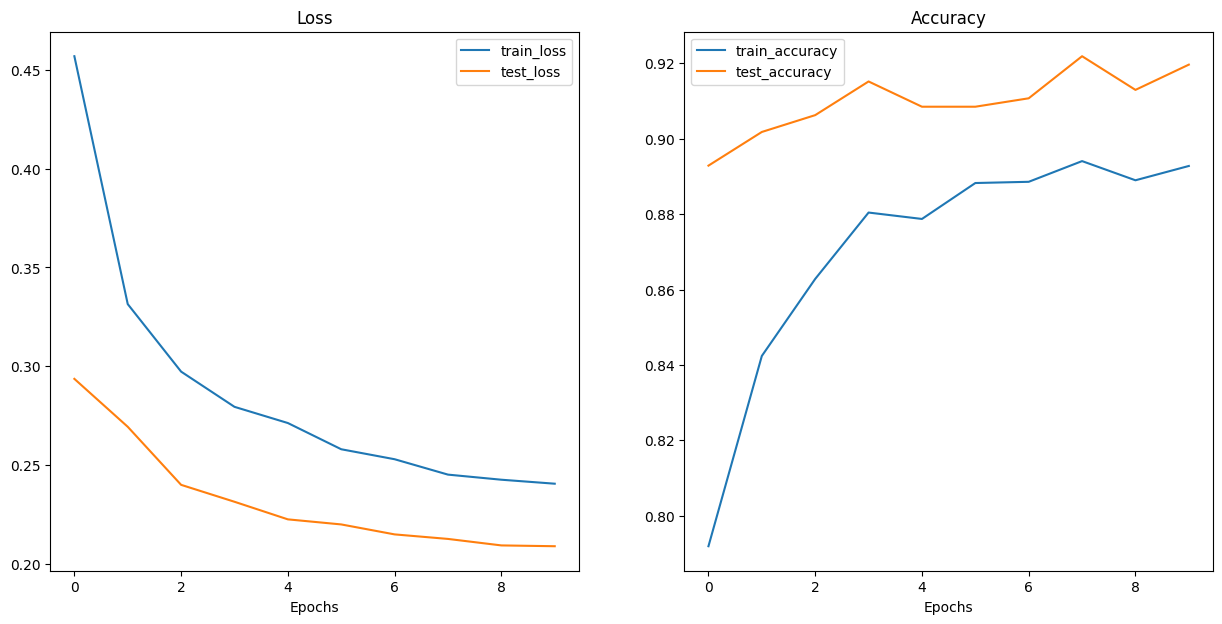

In [ ]:
# plot loss curves
helper_functions.plot_loss_curves(effnetb2_results)

# Save model to path

In [27]:
# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


# Check size of the model

In [28]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [29]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.08462864551693201,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# Making Predictions

In [31]:
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

# Create a function to make predictions and store results

In [43]:
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict
import pathlib 

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module, 
                   transform: torchvision.transforms, 
                   class_names: list[str], 
                   device: str = "cuda") -> List[Dict]:
    
    # create empty list to store prediction dicts 
    pred_list = []
    
    # loop through target paths
    for path in tqdm(paths):
        # create empty dict to store prediction info
        pred_dict = {}
        
        # get the sample path and true class name 
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name 
        
        # start prediciton timer
        start_time = timer()
        
        # open image path
        img = Image.open(path)
        
        # transform the image, add batch dim (unsqueeze) and send to correct device
        transform_image = transform(img).unsqueeze(0).to(device)
        
        # preapre the model for inferenece
        model.to(device)
        model.eval()
        
        # get prediction prob, label, and class
        with torch.inference_mode():
            pred_logit = model(transform_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim = 1)
            pred_class = class_names[pred_label.cpu()]
            
            # make sure things in the dictionary are on CPU
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # end the timer
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)
            
        # see if prediction matches
        pred_dict["correct"] = class_name == pred_class
        
        # add the dict to the list
        pred_list.append(pred_dict)
        
    # return the list of dict
    return pred_list

# Make predictions with effnetB2

In [44]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

100%|██████████| 150/150 [00:06<00:00, 21.98it/s]


In [45]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9988,
  'pred_class': 'pizza',
  'time_for_pred': 0.0622,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9509,
  'pred_class': 'pizza',
  'time_for_pred': 0.0457,
  'correct': True}]

# Create Pandas Dataframe to inspect

In [46]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9988,pizza,0.0622,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9509,pizza,0.0457,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9985,pizza,0.0475,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9733,pizza,0.0460,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9851,pizza,0.0446,True


In [47]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [48]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0453 seconds


# Using Gradio Demo

In [50]:
import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 5.21.0


inputs -> ML model -> outputs  
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken

In [51]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

# Create Predict Function

In [57]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()
    
    # transform image and add batch dim
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # put model in eval mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)
        
    # create prediction label and prediction prob
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time
    

In [58]:
import random

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# open image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\steak\289822.jpg

Prediction label and probability dictionary: 
{'pizza': 0.004519496578723192, 'steak': 0.9843215942382812, 'sushi': 0.011158893816173077}
Prediction time: 0.06489 seconds


In [59]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\sushi\\2352914.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\472912.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\724290.jpg']]

# Building a Gradio Interface

In [60]:
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

In [61]:
# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

In [63]:
# Launch the demo!
#demo.launch(debug=False, # print errors locally?
#           share=True) # generate a publically shareable URL?

# Create Demo Directory to deploy on Hugging Face Spaces

In [65]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, 
                                exist_ok=True)

In [66]:
# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [67]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [69]:
# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: True


'Compress-Archive' is not recognized as an internal or external command,
operable program or batch file.
